In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from dateutil import tz
import glob

%matplotlib inline

In [2]:
# Read in Shapefile
cat_gdf = geopandas.read_file(glob.glob('data/gtwo_areas_*.shp')[0])
origin_points = geopandas.read_file(glob.glob('data/gtwo_points_*.shp')[0])
line_path = geopandas.read_file(glob.glob('data/gtwo_lines_*.shp')[0])

In [3]:
# Set Coordinate Reference System for the map
map_crs = ccrs.Mercator()

# Set Coordinate Reference System from the Shapefile Data
data_crs = ccrs.PlateCarree()

In [4]:
# Set colors
cat_plot_colors = {'Low': 'yellow',
                   'Medium': 'orange',
                   'High': 'red'}

# Generate legend patches
legend_patches = []
for risk in cat_plot_colors.keys():
    patch = mpatches.Patch(color=cat_plot_colors[risk], label=risk)
    legend_patches.append(patch)

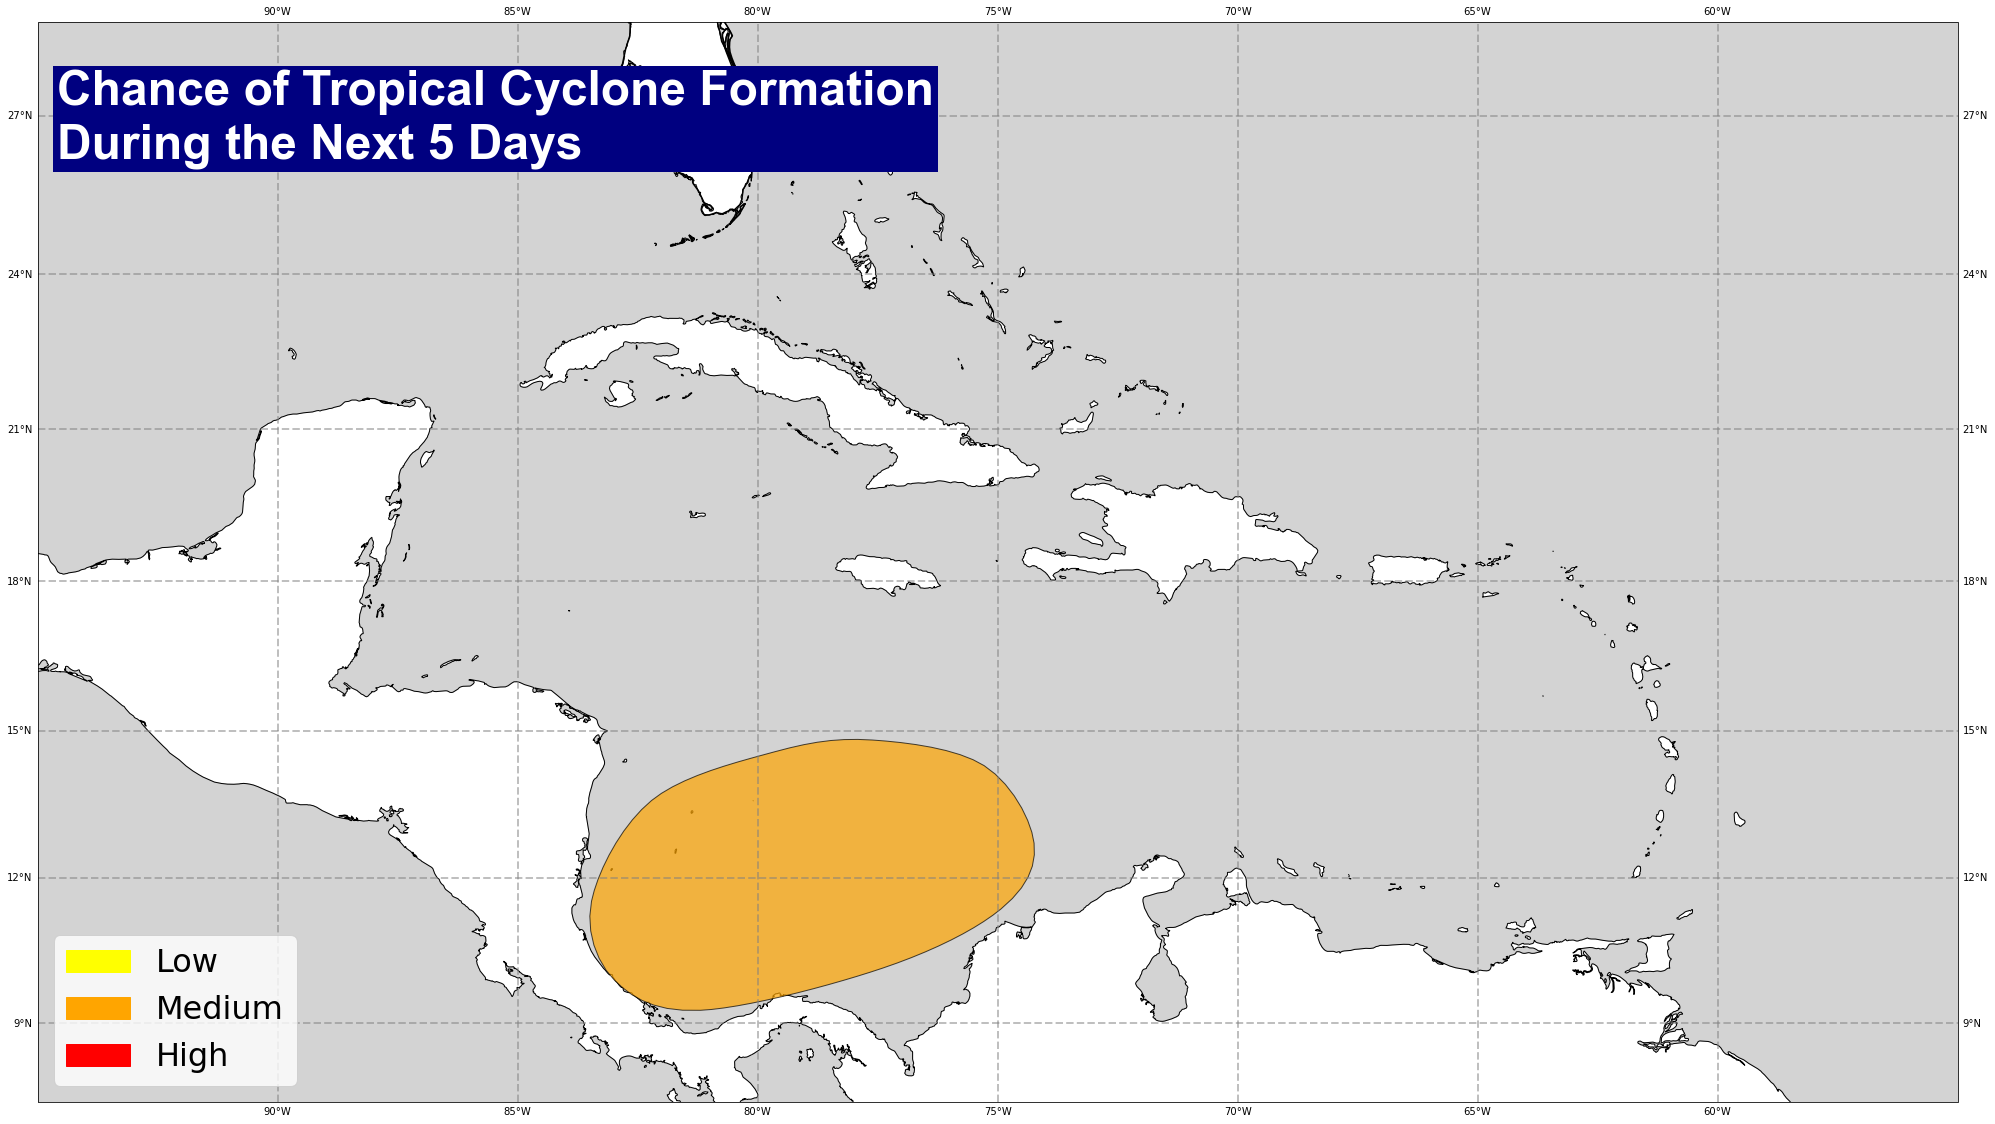

In [10]:
# Setup matplotlib figure
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=map_crs)
ax.set_adjustable('datalim')

#Atlantic and eastern Pacific
#ax.set_extent([-140, -10, 5, 42], ccrs.PlateCarree())

#Florida
#ax.set_extent([-100, -65, 20, 36], ccrs.PlateCarree())

#Atlantic Basin
#ax.set_extent([-100, -10, 5, 42], ccrs.PlateCarree())

#Caribbean
ax.set_extent([-95, -55, 0, 35], ccrs.PlateCarree())

# Setup borders (states, countries, coastlines, etc)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.5)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')


# Plot the polygons showing the potential development areas
for key in cat_plot_colors.keys():
    geometries = cat_gdf[cat_gdf['RISK5DAY'] == key]
    # Check to see if there an area outlooked at all. If so, add the polygons to the map.
    if len(geometries) > 0:
        ax.add_geometries(geometries['geometry'], crs=data_crs,
                          facecolor=cat_plot_colors[key], edgecolor='black',
                          alpha=0.7)

# Plot the origin points of the areas that may develop at a later time
points = origin_points['geometry']
if len(points) > 0:
    ax.scatter([point.x for point in points],
               [point.y for point in points],
                c='black', marker='X', s=300, zorder=2, transform=data_crs)

# Plot the path from the origin points to the potential development areas
if len(line_path['geometry']) > 0:
    ax.add_geometries(line_path['geometry'], crs=data_crs, 
                      facecolor='none', edgecolor='black', linewidth=3, zorder=4, 
                      linestyle="dashed")

# Plot the legend
plt.legend(handles=legend_patches, fontsize=32, loc='lower left')

# Set title
ax.set_title('Chance of Tropical Cyclone Formation\nDuring the Next 5 Days', loc='left', 
             ha='left', va='top', fontsize=48, color='white', 
             fontweight='bold', fontname='Arial', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'nhc'
plt.savefig(f'{graphics_dir}/twoat.png', dpi=72)